In [32]:
from matplotlib import pyplot as plt
import networkx as nx
import numpy as np
import sys
from argparse import Namespace
def viewInd(ind, taskName):
  env = {'input_size':12, 'output_size':3, 'in_out_labels':['x','y','vx','vy',\
                   'bx','by','bvx','bvy',\
                   'ox','oy','ovx','ovy', \
                   'x','y','jump']}
  env = Namespace(**env)
  if isinstance(ind, str):
    ind = np.loadtxt(ind, delimiter=',') 
    wMat = ind[:,:-1]
    aVec = ind[:,-1]
  else:
    wMat = ind.wMat
    aVec = np.zeros((np.shape(wMat)[0]))  
  print('# of Connections in ANN: ', np.sum(wMat!=0))
    
  # Create Graph
  nIn = env.input_size+1 # bias
  nOut= env.output_size
  G, layer= ind2graph(wMat, nIn, nOut)
  pos = getNodeCoord(G,layer,taskName)
    
  # Draw Graph
  fig = plt.figure(figsize=(10,10), dpi=100)
  ax = fig.add_subplot(111)
  drawEdge(G, pos, wMat, layer)
  nx.draw_networkx_nodes(G,pos,\
    node_color='lightblue',node_shape='o',\
    cmap='terrain',vmin=0,vmax=6)
  drawNodeLabels(G,pos,aVec) 
  labelInOut(pos,env)
  
  plt.tick_params(
    axis='both',       # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,
    labelleft=False,
    labelbottom=False) # labels along the bottom edge are off
    
  return fig, ax


def ind2graph(wMat, nIn, nOut):
    hMat = wMat[nIn:-nOut,nIn:-nOut]
    hLay = getLayer(hMat)+1

    if len(hLay) > 0:
      lastLayer = max(hLay)+1
    else:
      lastLayer = 1
    L = np.r_[np.zeros(nIn), hLay, np.full((nOut),lastLayer) ]
    print(L)
    # L[-3:] = 4
    # L[-6:-3] = 3
    # L[-4] = 3
    layer = L
    order = layer.argsort()
    layer = layer[order]

    wMat = wMat[np.ix_(order,order)]
    nLayer = layer[-1]

    # Convert wMat to Full Network Graph
    rows, cols = np.where(wMat != 0)
    edges = zip(rows.tolist(), cols.tolist())
    G = nx.DiGraph()
    G.add_edges_from(edges)
    return G, layer


def getNodeCoord(G,layer,taskName):
    env = {'input_size':12, 'output_size':3, 'in_out_labels':['x','y','vx','vy',\
                   'bx','by','bvx','bvy',\
                   'ox','oy','ovx','ovy', \
                   'x','y','jump']}
    env = Namespace(**env)

    # Calculate positions of input and output
    nIn  = env.input_size+1
    nOut = env.output_size 
    nNode= len(G.nodes)
    fixed_pos = np.empty((nNode,2))
    fixed_nodes = np.r_[np.arange(0,nIn),np.arange(nNode-nOut,nNode)]

    # Set Figure dimensions
    fig_wide = 10
    fig_long = 5

    # Assign x and y coordinates per layer
    x = np.ones((1,nNode))*layer # Assign x coord by layer
    x = (x/np.max(x))*fig_wide # Normalize

    _, nPerLayer = np.unique(layer, return_counts=True)

    y = cLinspace(-2,fig_long+2,nPerLayer[0])
    for i in range(1,len(nPerLayer)):
      if i%2 == 0:
        y = np.r_[y,cLinspace(0,fig_long,nPerLayer[i])]
      else:
        y = np.r_[y,cLinspace(-1,fig_long+1,nPerLayer[i])]

    fixed_pos = np.c_[x.T,y.T]
    pos = dict(enumerate(fixed_pos.tolist()))
    
    return pos
  
def labelInOut(pos, env):
  nIn  = env.input_size+1
  nOut = env.output_size 
  nNode= len(pos)
  fixed_nodes = np.r_[np.arange(0,nIn),np.arange(nNode-nOut,nNode)]

  if len(env.in_out_labels)>0:
    stateLabels = ['bias'] + env.in_out_labels
    labelDict = {}
  for i in range(len(stateLabels)):
        print(i)
        labelDict[fixed_nodes[i]] = stateLabels[i]
      
  for i in range(nIn):
    plt.annotate(labelDict[i], xy=(pos[i][0]-0.5, pos[i][1]), xytext=(pos[i][0]-2.5, pos[i][1]-0.5),\
               arrowprops=dict(arrowstyle="->",color='k',connectionstyle="angle"))

  for i in range(nNode-nOut,nNode):
    plt.annotate(labelDict[i], xy=(pos[i][0]+0.1, pos[i][1]), xytext=(pos[i][0]+1.5, pos[i][1]+1.0),\
               arrowprops=dict(arrowstyle="<-",color='k',connectionstyle="angle"))

    
def drawNodeLabels(G, pos, aVec):  
  actLabel = np.array((['','( + )','(0/1)','(sin)','(gau)','(tanh)',\
                        '(sig)','( - )', '(abs)','(relu)','(cos)']))
  listLabel = actLabel[aVec.astype(int)]  
  label = dict(enumerate(listLabel))
  nx.draw_networkx_labels(G,pos,labels=label)  
  
  
def drawEdge(G, pos, wMat, layer):
    wMat[np.isnan(wMat)]=0
    # Organize edges by layer
    _, nPerLayer = np.unique(layer, return_counts=True)
    edgeLayer = []
    layBord = np.cumsum(nPerLayer)
    for i in range(0,len(layBord)):
      tmpMat = np.copy(wMat)
      start = layBord[-i]
      end = layBord[-i+1]
      tmpMat[:,:start] *= 0
      tmpMat[:,end:] *= 0
      rows, cols = np.where(tmpMat != 0)
      edges = zip(rows.tolist(), cols.tolist())
      edgeLayer.append(nx.DiGraph())
      edgeLayer[-1].add_edges_from(edges)
    edgeLayer.append(edgeLayer.pop(0)) # move first layer to correct position

    # Layer Colors
    for i in range(len(edgeLayer)):
      C = [i/len(edgeLayer)] * len(edgeLayer[i].edges) 
      nx.draw_networkx_edges(G,pos,edgelist=edgeLayer[i].edges,\
        alpha=.75,width=1.0,edge_color=C,edge_cmap=plt.cm.viridis,\
        edge_vmin=0.0, edge_vmax=1.0,arrowsize=8)

def getLayer(wMat):
  '''
  Traverse wMat by row, collecting layer of all nodes that connect to you (X).
  Your layer is max(X)+1
  '''
  wMat[np.isnan(wMat)] = 0  
  wMat[wMat!=0]=1
  nNode = np.shape(wMat)[0]
  layer = np.zeros((nNode))
  while(True): # Loop until sorting doesn't help any more
    prevOrder = np.copy(layer)
    for curr in range(nNode):
      srcLayer=np.zeros((nNode))
      for src in range(nNode):
        srcLayer[src] = layer[src]*wMat[src,curr]   
      layer[curr] = np.max(srcLayer)+1    
    if all(prevOrder==layer):
        break
  return layer-1

def cLinspace(start,end,N):
  if N == 1:
    return np.mean([start,end])
  else:
    return np.linspace(start,end,N)

def lload(fileName):
  return np.loadtxt(fileName, delimiter=',') 

# of Connections in ANN:  156
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2.
 2.]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

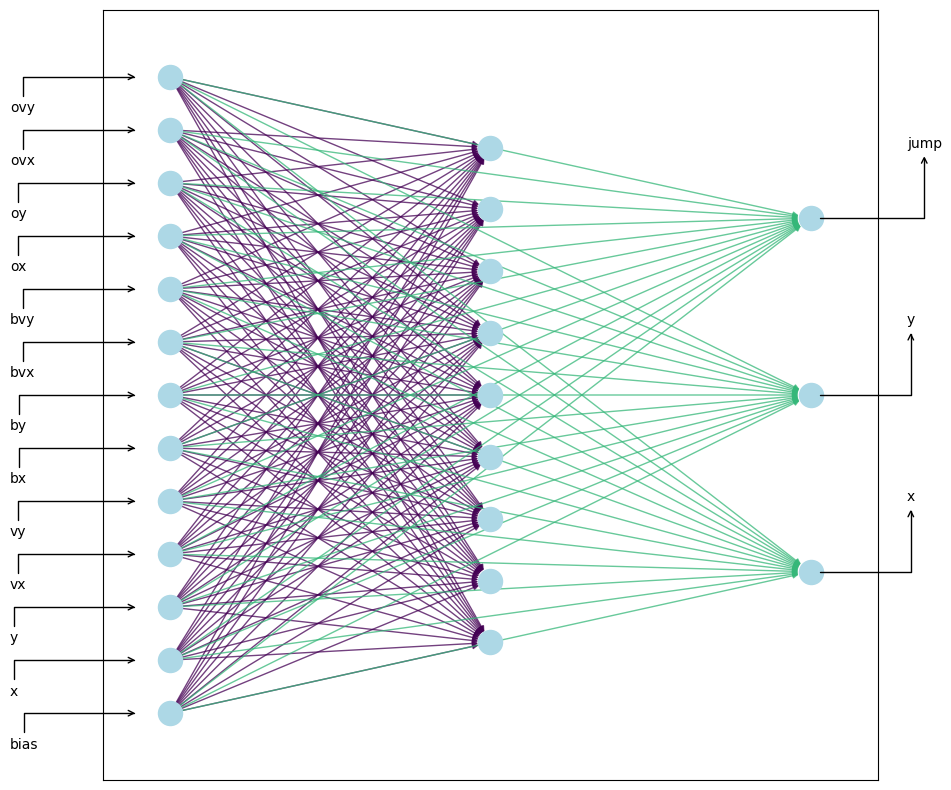

In [33]:
from neat_src.utils import *
import json
from neat_src import Neat
from argparse import Namespace
import numpy as np 
with open("config.json") as data_file: 
    hyp = json.load(data_file)

# Globalize for visibility during multi-processing
global neat
neat = Neat(hyp)
savedpop = loadPop('log/latestrun4_pop.obj')
neat.pop = savedpop
ind = neat.pop[3]
# ind.wMat = np.res
viewInd(ind, None)